In [50]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
import datetime as dt

In [51]:
df1 = pd.read_excel("../data/bronze.xlsx")
df2 = pd.read_excel("../data/bronze.xlsx", sheet_name=1)
df = pd.concat([df1, df2])

In [52]:
df.rename(columns={"Customer ID": "Customer_id"}, inplace=True)
df = df.drop_duplicates()
df = df.dropna()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df["TotalPrice"] = df["Quantity"] * df["Price"]
df = df[(df['StockCode'] != 'TEST001') & (df['StockCode'] != 'D') & (df['StockCode'] != 'M')]

In [53]:
df = df.drop(df[df['Price'] == 0].index)

In [54]:
df_2009_2010 = df[(df['InvoiceDate'].dt.year == 2010) | (df['InvoiceDate'].dt.year == 2009)]
#df_2009_2010_5 = df[((df['InvoiceDate'].dt.year == 2010) | (df['InvoiceDate'].dt.year == 2009)) | ((df['InvoiceDate'].dt.day <= 5) & (df['InvoiceDate'].dt.month == 1) & (df['InvoiceDate'].dt.year == 2011))]
df_2009_2010_15= df[((df['InvoiceDate'].dt.year == 2010) | (df['InvoiceDate'].dt.year == 2009)) | ((df['InvoiceDate'].dt.year == 2011) & (df['InvoiceDate'].dt.month == 1) & (df['InvoiceDate'].dt.day <= 15))]
df_2009_2010_30 = df[((df['InvoiceDate'].dt.year == 2010) | (df['InvoiceDate'].dt.year == 2009)) | ((df['InvoiceDate'].dt.year == 2011) & (df['InvoiceDate'].dt.month == 1))]
df_2009_2010_60= df[((df['InvoiceDate'].dt.year == 2010) | (df['InvoiceDate'].dt.year == 2009)) | ((df['InvoiceDate'].dt.year == 2011) & (df['InvoiceDate'].dt.month.isin([1, 2])))]
df_2009_2010_90 = df[((df['InvoiceDate'].dt.year == 2010) | (df['InvoiceDate'].dt.year == 2009)) | ((df['InvoiceDate'].dt.year == 2011) & (df['InvoiceDate'].dt.month.isin([1, 2, 3])))]
df_2009_2010_180 = df[((df['InvoiceDate'].dt.year == 2010) | (df['InvoiceDate'].dt.year == 2009)) | ((df['InvoiceDate'].dt.year == 2011) & (df['InvoiceDate'].dt.month <= 6))]

In [55]:
print(df_2009_2010.shape,df_2009_2010_5.shape ,df_2009_2010_15.shape,df_2009_2010_90.shape, df_2009_2010_180.shape )

(421804, 9) (423666, 9) (431313, 9) (491019, 9) (570124, 9)


In [56]:
def rfm(data):
    
    
    today_date = dt.datetime(2011, 12, 11)
    data_rfm = data.groupby("Customer_id").agg({
                                     "InvoiceDate": lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     "Invoice": lambda x: x.astype(str)[~x.astype(str).str.startswith('C')].nunique(),
                                     "TotalPrice": [ lambda x : x.sum() , lambda x: abs(x[x < 0].sum() * 100 / x[x > 0].sum()) if x[x > 0].sum() != 0 else 100]
                                     
                                     })
    
    
    data_rfm.columns = ["recency", "frequency", "monetary", "pourcentage"]
    data_rfm['basket_average'] = data_rfm['monetary'] / data_rfm['frequency']
    
    
    quantile_threshold = 0.95
    quantiles = data_rfm.quantile(quantile_threshold)
    data_rfm = data_rfm[(data_rfm <= quantiles).all(axis=1)]
    
    
    c = ['recency', 'frequency', 'monetary', 'pourcentage', 'basket_average']
    scaler = RobustScaler()
    scaler.fit(data_rfm[c])
    data_rfm[c] = scaler.transform(data_rfm[c])
    
    
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    kmeans.fit(data_rfm)
    data_rfm["cluster_labels"] = kmeans.labels_
    

    return data_rfm

In [57]:
rfm(df_2009_2010)

,recency,frequency,monetary,pourcentage,basket_average,cluster_labels
Customer_id,,,,,,
12347.0,-0.446809,0.00,0.636980,0.000000,1.940941,3
12348.0,-0.542553,0.00,0.443509,0.000000,1.428890,0
12349.0,-0.021277,0.25,1.866062,0.784215,3.025548,3
12351.0,-0.361702,-0.25,-0.312352,0.000000,0.167931,0
12352.0,-0.361702,0.00,-0.272546,0.000000,-0.466259,0
...,...,...,...,...,...,...
18283.0,-0.287234,1.00,-0.016667,0.000000,-0.803785,0
18284.0,0.212766,-0.25,-0.186303,4.696927,0.835151,2
18285.0,2.670213,-0.25,-0.195291,0.000000,0.787573,0


In [58]:
# Calculer RFM pour chaque DataFrame
rfm_2009_2010 = rfm(df_2009_2010)
#rfm_2009_2010_5 = rfm(df_2009_2010_5)
rfm_2009_2010_15 = rfm(df_2009_2010_15)
rfm_2009_2010_30 = rfm(df_2009_2010_30)
rfm_2009_2010_60 = rfm(df_2009_2010_60)
rfm_2009_2010_90 = rfm(df_2009_2010_90)
rfm_2009_2010_180 = rfm(df_2009_2010_180)
rfm_2009_2010_360 = rfm(df)

# Fusionner avec le RFM de df_2009_2010 en utilisant l'index
merged_rfm_2009_2010 = rfm_2009_2010.merge(rfm_2009_2010['cluster_labels'], left_index=True, right_index=True)
#merged_rfm_2009_2010_5 = rfm_2009_2010.merge(rfm_2009_2010_5['cluster_labels'], left_index=True, right_index=True)
merged_rfm_2009_2010_15 = rfm_2009_2010.merge(rfm_2009_2010_15['cluster_labels'], left_index=True, right_index=True)
merged_rfm_2009_2010_30 = rfm_2009_2010.merge(rfm_2009_2010_30['cluster_labels'], left_index=True, right_index=True)
merged_rfm_2009_2010_60 = rfm_2009_2010.merge(rfm_2009_2010_60['cluster_labels'], left_index=True, right_index=True)
merged_rfm_2009_2010_90 = rfm_2009_2010.merge(rfm_2009_2010_90['cluster_labels'], left_index=True, right_index=True)
merged_rfm_2009_2010_180 = rfm_2009_2010.merge(rfm_2009_2010_180['cluster_labels'], left_index=True, right_index=True)
merged_rfm_2009_2010_360 = rfm_2009_2010.merge(rfm_2009_2010_360['cluster_labels'], left_index=True, right_index=True)


In [59]:
merged_rfm_2009_2010_60

,recency,frequency,monetary,pourcentage,basket_average,cluster_labels_x,cluster_labels_y
Customer_id,,,,,,,
12347.0,-0.446809,0.00,0.636980,0.000000,1.940941,3,0
12348.0,-0.542553,0.00,0.443509,0.000000,1.428890,0,2
12351.0,-0.361702,-0.25,-0.312352,0.000000,0.167931,0,2
12352.0,-0.361702,0.00,-0.272546,0.000000,-0.466259,0,2
12353.0,-0.010638,-0.25,-0.296725,0.000000,0.250652,0,2
...,...,...,...,...,...,...,...
18283.0,-0.287234,1.00,-0.016667,0.000000,-0.803785,0,2
18284.0,0.212766,-0.25,-0.186303,4.696927,0.835151,2,3
18285.0,2.670213,-0.25,-0.195291,0.000000,0.787573,0,2


In [63]:
list_data = [merged_rfm_2009_2010, merged_rfm_2009_2010_15, merged_rfm_2009_2010_30, merged_rfm_2009_2010_60, merged_rfm_2009_2010_90, merged_rfm_2009_2010_180, merged_rfm_2009_2010_360]

In [64]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(merged_rfm_2009_2010_180['cluster_labels_x'], merged_rfm_2009_2010_180['cluster_labels_y'])

0.7438475517018802

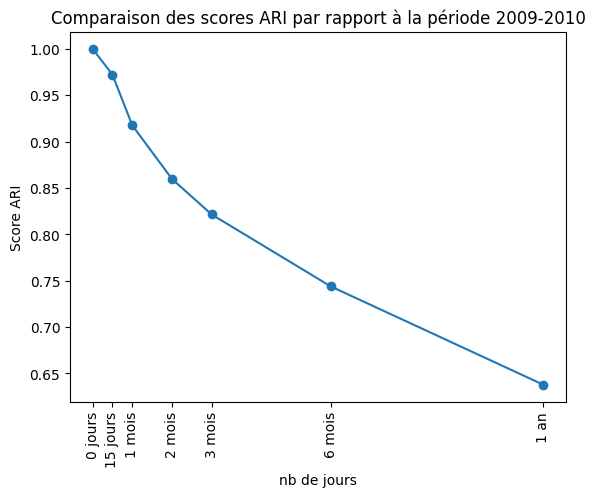

In [66]:
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt


ari_scores = []

# Calcul du score ARI pour chaque data frame par rapport au premier élément
for df in list_data:
    ari_score = adjusted_rand_score(df['cluster_labels_x'], df['cluster_labels_y'])
    ari_scores.append(ari_score)

# Indices correspondant aux positions des data frames dans la liste
indices = [0, 15, 30, 60, 90, 180, 341]

# Tracé de la courbe des scores ARI
plt.plot(indices, ari_scores, marker='o')
plt.xlabel('nb de jours')
plt.ylabel('Score ARI')
plt.title('Comparaison des scores ARI par rapport à la période 2009-2010')
plt.xticks(indices, ['0 jours', '15 jours', '1 mois', '2 mois', '3 mois', '6 mois', '1 an'], rotation=90)
plt.show()
